In [1]:
import numpy as np
import scipy
import scipy.stats
import torch as t
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [2]:
%matplotlib inline

In [3]:
print(t.cuda.is_available())
device = t.device("cuda" if t.cuda.is_available() else "cpu")

True


In [4]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)

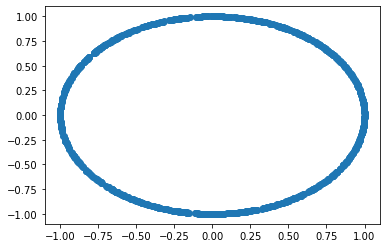

In [5]:
plt.scatter(data[:,0], data[:,1]);

In [6]:
data_t = t.from_numpy(data)
print(len(data_t))

1000


In [7]:
data_t = data_t.to(device)

In [8]:
discriminator = Sequential(Linear(2,512), LeakyReLU(0.3, inplace=True),
                           Linear(512,256), LeakyReLU(0.3, inplace=True),
                           Linear(256,256), LeakyReLU(0.3, inplace=True),
                           Linear(256, 128), LeakyReLU(0.3, inplace=True),
                           Linear(128, 128), LeakyReLU(0.3, inplace=True),
                           Linear(128, 64), LeakyReLU(0.3, inplace=True),
                           Linear(64, 2),
                           Sigmoid()
                          ) #dummy discriminator: please subsitute you own implementation 

In [9]:
discriminator = discriminator.to(device) 

In [10]:
generator = Sequential(Linear(2, 512), LeakyReLU(),
                       Linear(512, 512), LeakyReLU(),
                       Linear(512, 256), LeakyReLU(),
                       Linear(256, 128), LeakyReLU(),
                       Linear(128, 2)
                      )# dummy generator: please subsitute you own implementation 

In [11]:
generator= generator.to(device)

In [12]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));
out_t = out_t.to(device)

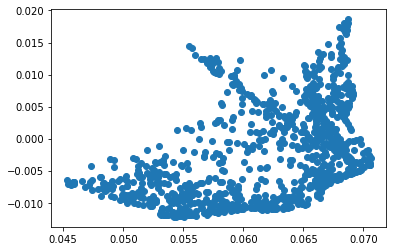

In [13]:
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1])

In [14]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [15]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

    1   0.83   1.05   0.21s 125.79s



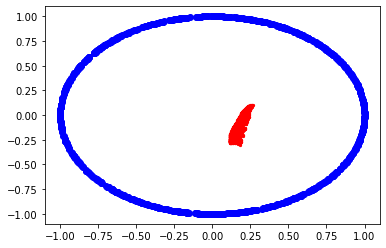

  101   0.90   3.54  20.14s  99.52s



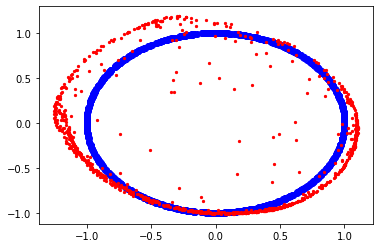

  201   1.27   2.42  40.20s  79.80s



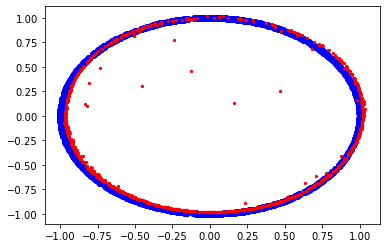

  301   0.47   6.92  60.69s  60.29s



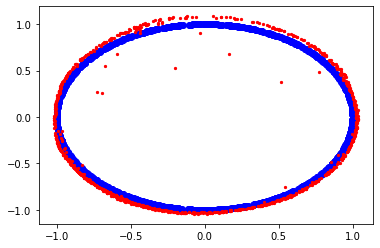

  401   0.88   2.76  80.47s  39.94s



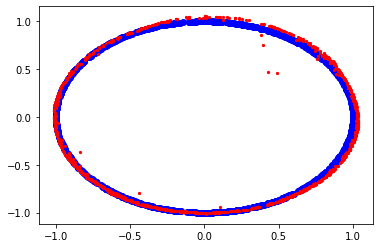

  501   0.46  15.65  99.31s  19.62s



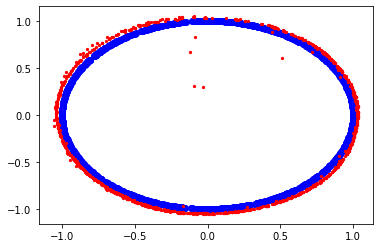

  601   0.69   3.81 118.01s  -0.20s



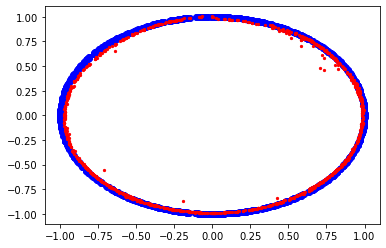

In [16]:
init_z = t.empty(1000,2,device=device).uniform_(-1,1)
loss = t.nn.BCELoss()
batch_size = 100
k_discriminator = 4
k_generator = 1
epochs = 600
start=time.time()
print_every=100

for epoch in range(1,epochs+2):
    for k in range(len(data_t)//batch_size):
        for di in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data_t)//batch_size )
            batch = data_t[kr*batch_size:(kr+1)*batch_size]
            real_labels = t.ones(batch_size, 2, device=device)
            d_real_loss= loss(discriminator(batch), 0.9*real_labels)           
            z = t.empty(batch_size, 2, device=device).uniform_(-1,1)
            g_out = generator(z)
            fake_labels = t.zeros(batch_size, 2, device=device)
            d_fake_loss = loss(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss           
            d_loss.backward()
            d_optimizer.step()
        for gi in range(k_generator):
            g_optimizer.zero_grad()
            z = t.empty(batch_size, 2, device=device).uniform_(-1,1)
            g_out=generator(z)
            g_loss = loss(discriminator(g_out), real_labels)
            g_loss.backward()
            g_optimizer.step()
    if epoch%print_every == 1:
        end = time.time()
        ellapsed = end - start
        time_per_epoch = ellapsed/epoch
        eta = time_per_epoch*(epochs-epoch)
        
        with t.no_grad():
            z = t.empty(len(data_t),2, device=device).uniform_(-1,1)
            real_labels = t.ones(len(data_t), 2, device=device)
            fake_labels = t.zeros(len(data_t), 2, device=device)
            g_out =  generator(z)
            dg_out = discriminator(g_out)
            d_loss =  loss(discriminator(data_t), real_labels)
            d_loss +=  loss(dg_out, fake_labels)
            g_loss = loss(dg_out, real_labels)
            out_t = generator(init_z);
            print('%5d %6.2f %6.2f %6.2fs %6.2fs\n' % (epoch, d_loss.item(), g_loss.item(), ellapsed, eta))
            plt.scatter(data[:,0], data[:,1], c='b')
            plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1], c='red', s=5)
            plt.show()

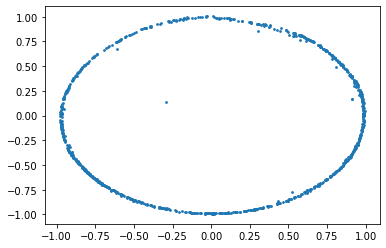

In [17]:
out_t = generator(t.empty(1000,2, device=device).uniform_(-1,1));
plt.scatter(out_t.data.cpu().numpy()[:,0],out_t.data.cpu().numpy()[:,1], s=3);

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

Update to Pegaz both the notebook and the trained generator.